# Analysis of the single assessment


In [62]:
import os, pickle
import numpy as np
import pandas as pd   # module to work with data in DataFrames.
import seaborn as sns  # module to plot DataFrames in an easy way
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.stats as stats
import scipy.constants as sc

Seaborn setup throughout the notebook.

In [63]:
# seaborn comes with default presets (called 'contents') for figure's aesthetics, 
# such as the font size, figure size etc.

sns.set_context('paper') # try: 'talk', 'poster', 'notebook'
sns.set_theme(style="ticks", palette="pastel")

# Set global color scheme for historic and modern images.
sns_palette_historic = ["m"]
sns_palette_modern = ["g"]

# Plot size and y limits.
sns_plot_size = (8*sc.golden_ratio, 8)
sns_half_plot_size = (4*sc.golden_ratio, 8)
sns_ylim = (-0.1, 9.1)

color_blue = '#4E92FF'

## Get the result files

In [64]:
single_result_dir = Path('../single_assessment/results').absolute()
single_result_file_names = os.listdir(single_result_dir)
single_result_file_names = list(filter(lambda name: str.startswith(name, 'result'), single_result_file_names))

single_result_files_paths = []
for name in single_result_file_names:
    single_result_files_paths.append(single_result_dir / name)

num_observer = len(single_result_files_paths)
print(f"Number observer: {num_observer}")

Number observer: 24


## Create dataframe

In [65]:
df = pd.DataFrame()
for index, path in enumerate(single_result_files_paths):
    df_tmp = pd.read_csv(path)
    df_tmp['observer'] = index
    df = pd.concat((df, df_tmp))


New column to save normalised values.
Scale perceived chroma to range [0,1]

In [66]:
df["normalise"] = df["response"] #/ 9

Add short ID of the image to the dataframe. And sort by id.

In [67]:
df['id'] = [s.split('_')[0] for s in df['test_image'].tolist()]
df = df.sort_values(by='id', ascending=True, key=lambda col: [int(img[1:]) for img in col])

In [68]:
df['type'] = [s[0] for s in df['id'].tolist()]

In [69]:
assert len(df) == (30 +15) * num_observer

## Sanity checks
We expect 30 historic and 15 modern images used during tests.
Only responses from [0, 9] accepted.

In [70]:
# sanity checks: how many groups do you expect per categorical variable?
assert len(df['test_image'].unique()) == 30 + 15
assert max(df['response'].unique()) <= 9
assert min(df['response'].unique()) >= 0
assert len(df) == (30 + 15) * len(single_result_file_names)
# Check number of observers.
assert len(df['observer'].unique()) == len(single_result_file_names)

# Check number of historic and modern images.
assert len(df[df['type'] == "H"]) == 30 * num_observer
assert len(df[df['type'] == "I"]) == 15 * num_observer

## Export dataframe

In [71]:
with open("single.pkl", mode="wb") as pkl_file:
    pickle.dump(df, pkl_file)

## Get average chroma values

In [72]:
# with open(Path('../image_generation/02_recolor/average_chroma_values.pkl'), mode='rb') as pkl_file:
#     average_chroma_values = pickle.load(pkl_file)

# df_average_chroma_values = pd.DataFrame(average_chroma_values)
# df_average_chroma_values.columns = ['test_image', 'chroma']

Sanity checks of the average chroma values.

In [73]:
# assert len(df_average_chroma_values) == len(df['test_image'].unique())
# assert max(df_average_chroma_values['chroma']) <= 100
# assert max(df_average_chroma_values['chroma']) >= 0.0

Add the average chroma value for every image to the dataframe.

In [74]:
# name = df_average_chroma_values['test_image'].unique()[0]
# chroma_list = []
# for image in df['test_image']:
#     s = df_average_chroma_values.loc[df_average_chroma_values['test_image'] == image, 'chroma']
#     chroma_list.append(s.iloc[0])

# list(chroma_list)
# df['chroma'] = chroma_list

Sanity check added chroma values to the original dataframe.

In [75]:
# for row in df.index:
#     name = df.loc[df.index == row, 'test_image'].iloc[0]
#     test_value = df.loc[df['test_image'] == name, 'chroma'].iloc[0]
#     verified_value = df_average_chroma_values.loc[df_average_chroma_values['test_image'] == name, 'chroma'].iloc[0]
#     assert np.isclose(test_value, verified_value)

Scale chroma values to [0, 9] range. And assert result.

In [76]:
# df['chroma'] = np.array(df['chroma'].tolist()) * (9/100)

# assert max(df['chroma']) <= 9
# assert min(df['chroma']) >= 0

## Dataframe

In [77]:
df

,test_image,response,resptime,observer,normalise,id,type
18,H0_1.0_chroma.JPG,3,5.851714,8,3,H0,H
10,H0_1.0_chroma.JPG,6,5.768565,20,6,H0,H
41,H0_1.0_chroma.JPG,5,0.774010,7,5,H0,H
1,H0_1.0_chroma.JPG,4,13.499934,6,4,H0,H
0,H0_1.0_chroma.JPG,5,1.011019,1,5,H0,H
...,...,...,...,...,...,...,...
37,H29_1.0_chroma.JPG,4,1.177412,16,4,H29,H
35,H29_1.0_chroma.JPG,3,5.101903,12,3,H29,H
43,H29_1.0_chroma.JPG,4,3.902607,6,4,H29,H
35,H29_1.0_chroma.JPG,2,2.654218,13,2,H29,H


Historic images: Dataframe with name, selected mean by observers and measured mean chroma.

In [78]:
# mean_lists = []
# for img_name in df_historic['test_image'].unique():
#     mean = np.mean(df_historic.loc[df_historic['test_image'] == img_name, 'response'].tolist())
#     chroma = df_historic.loc[df_historic['test_image'] == img_name, 'chroma'].iloc[0]
#     mean_lists.append([img_name, mean, chroma])

# df_historic_mean = pd.DataFrame(mean_lists)
# df_historic_mean.columns = ['test_image', 'mean', 'chroma']
# df_historic_mean

### Historic plots

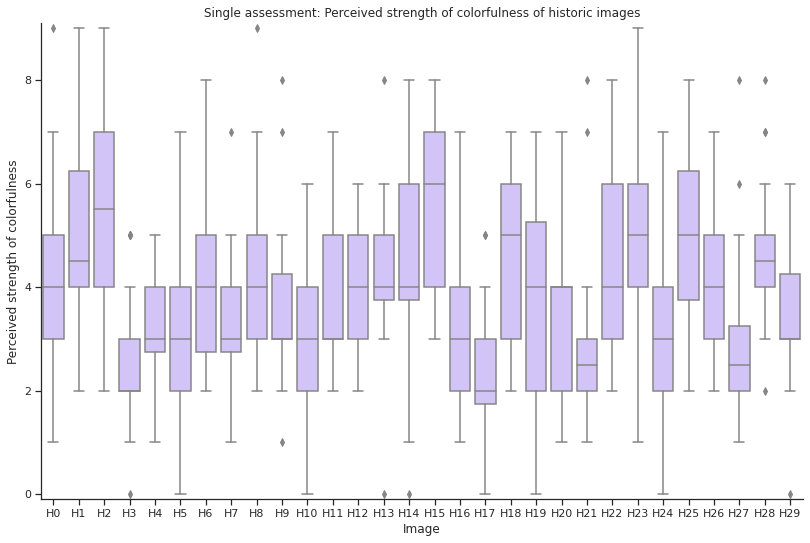

In [79]:
g = sns.catplot(
    x='id',
    y='normalise',
    data=df[df["type"] == "H"],
    kind='box',
    ci='sd',
    palette=sns_palette_historic
)

g.fig.set_size_inches(sns_plot_size)


g.set_axis_labels("Image", "Perceived strength of colorfulness")

g.set(title="Single assessment: Perceived strength of colorfulness of historic images")

g.set(ylim = sns_ylim)
sns.despine()
g.savefig("single_historic.png", dpi=400)

## Modern plot

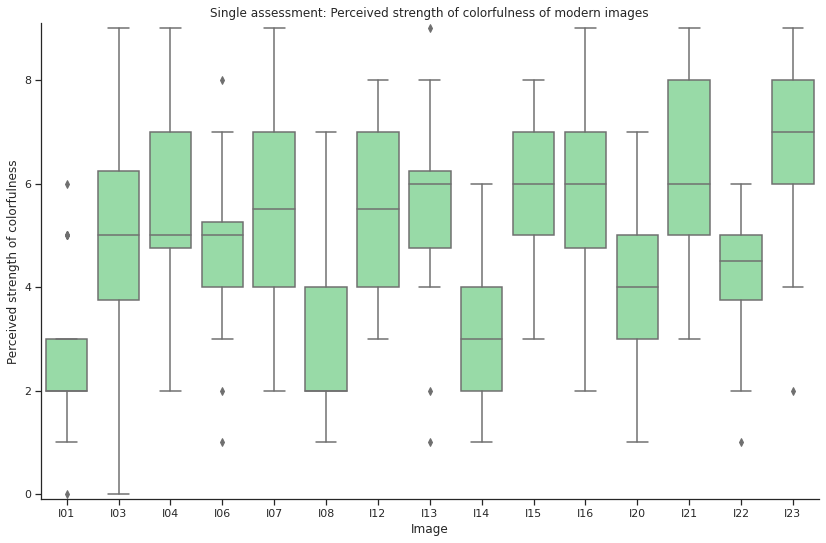

In [80]:
g = sns.catplot(
    x='id',
    y='normalise',
    data=df[df["type"] == "I"],
    kind='box',
    ci='sd',
    palette=sns_palette_modern
)

#g.set_xlabel("Image")
#g.set_ylabel("Chroma response")
g.set_axis_labels("Image", "Perceived strength of colorfulness")
g.fig.set_size_inches(sns_plot_size)
g.set(title="Single assessment: Perceived strength of colorfulness of modern images")

g.set(ylim = sns_ylim)
g.savefig("single_modern.png", dpi=400)

## Plot of both groups

In [81]:
#means = []
#for img in df[df["type"] == "H"]["id"].unique():
#    means.append((img, "H", np.median(df[df["id"] == img]["normalise"])))#

#for img in df[df["type"] == "I"]["id"].unique():
#    means.append((img, "I", np.median(df[df["id"] == img]["normalise"])))
    
#df_mean = pd.DataFrame(means)
#df_mean.columns = ["id", "type", "mean"]

# Check new dataframe with one image id.
#assert np.isclose(np.median(df[df["id"] == "I01"]["normalise"]), df_mean[df_mean["id"] == "I01"]["mean"])

In [82]:
observer_hist_modern = []
for ob in df[df["type"] == "H"]["observer"].unique():
    observer_hist_modern.append((
        ob,
        "H",
        np.mean(df[(df["observer"] == ob) & (df["type"] == "H")]["normalise"])
    ))
for ob in df[df["type"] == "H"]["observer"].unique():
    observer_hist_modern.append((
        ob,
        "I",
        np.mean(df[(df["observer"] == ob) & (df["type"] == "I")]["normalise"])
    ))


df_observer_hist_modern = pd.DataFrame(observer_hist_modern)
df_observer_hist_modern.columns = ["observer", "type", "mean"]

In [83]:
#with open("single.pkl", mode="wb") as pkl_file:
#    pickle.dump(df_observer_hist_modern, pkl_file)

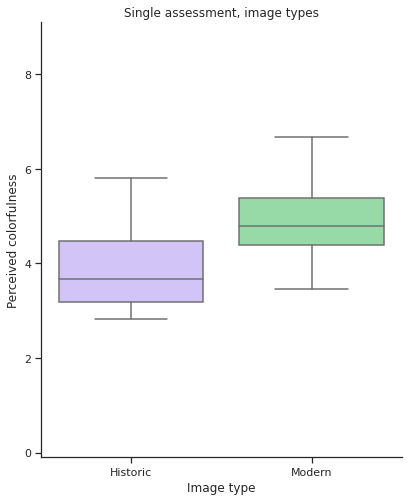

In [88]:
g = sns.boxplot(
    x="type",
    y="mean",
    palette=[sns_palette_historic[0], sns_palette_modern[0]],
    #data=df_mean,
    data=df_observer_hist_modern,
    #showmeans=True,
    meanprops={
        "marker":"o",
        "markerfacecolor":"black", 
        "markeredgecolor":"black",
        "markersize":"5"
    }
)

g.figure.set_size_inches(sns_half_plot_size)

g.set(title="Single assessment, image types")
g.set(ylim = sns_ylim)

g.set_xlabel("Image type")
g.set_ylabel("Perceived colorfulness")
g.set(xticklabels=["Historic", "Modern"])

sns.despine()

g.figure.savefig("single_both.png", dpi=400)

## t-Test

In [85]:
#historic = df[df["type"] == "H"]["normalise"]
#modern = df[df["type"] == "I"]["normalise"]

#assert len(historic) == 30 * num_observer
#assert len(modern) == 15 * num_observer


In [86]:
historic = df_observer_hist_modern[df_observer_hist_modern["type"] == "H"]["mean"]
modern = df_observer_hist_modern[df_observer_hist_modern["type"] == "I"]["mean"]

In [87]:
tstat, p_value = stats.ttest_rel(historic, modern)

print('p-value:', p_value)
print(f"P-value << 0.05: {np.less(p_value, 0.05)}.")

p-value: 4.0444657326988224e-08
P-value << 0.05: True.
